## Introduction on how to use the simulation

In [1]:
# Imports and loading of NEURON dll
import numpy as np
from neuron import h
import simulation as sim
import matplotlib.pyplot as plt
import stimulus_pulse as sp
import extracellular as ex
import helperFuncs as hf

## Example of running a full simulated electrical stimulation experiment

### Setting up the simulated cell

In [2]:
# clear all NEURON sims. Required if you are going to be running many exps
#  in Jupyter notebooks.
for sec in h.allsec():
   h.delete_section(sec=sec)

In [3]:
# Code to setup a single simulated RGC
RGC = sim.Local_Cell()
filename = 'cell_param_files/params_35.csv'
RGC.build_cell(filename, 'mammalian_spike_35')

After any change to cell geometry or nseg, be sure to invoke setpointers()


In [4]:
# print out where the center of the soma is located and shift if needed
#  Note, behind the scenes this is shifting all simualted compartments by 
#  the necessary x,y,z transforms to get the cell to the right spot 
print('Current soma center is located at: ', RGC.soma_center)
# RGC.shift_cell_x_y_z(0,0,0)
# print('New soma center is located at: ', RGC.soma_center)

Current soma center is located at:  [-11.9399995803833, 0.0, 10.0]


### Setting up the electrical stimulus 

In [12]:
### Most features of the stimulus are set up a struct (dict) called Stim 
Stim = {}

# temporal features of the sitmulus 
Stim['pulseShape'] = 'triphasic'
Stim['dt'] = .005 # units: [ms]
Stim['delay'] = 10 # units: [ms]
Stim['dur'] = 0.05 # units: [ms]
Stim['stop'] = 80 # units: [ms]
Stim['amp'] = 3.15 # units: [uA]

# calibration phase of the stimulus 
Stim['initDur'] = 50 # units: [ms]
Stim['initDt'] = 1 # units: [ms]
Stim['vInit'] = -70 # units: [mV] #TODO: Old is -70

# spatial features of the stimulus 
# --> specifically defining the electrode geometry 
Stim['electrodes'] = [[-1000,0,57]] # units: [um]  # -1000,0,49
Stim['electrode_type'] = 'disk'
Stim['rhoExt'] = 1000 # Ohm*cm
Stim['elecDiam'] = 15 # um 15
Stim['polarity'] = -1 # anodic == 1; cathodic == -1 

Stim['pulseRatioTri'] = [-2/3,1,-1/3]
Stim['pulseRatioBi'] = [1,-1]
Stim['frequency'] = 10 # units: [Hz]

In [13]:
# have to set transfer impedances ANY TIME stimulus parameters are changed!! 
# Stim['electrodes'] = [[-1000,0,49]] # electrode location
hf.setupTransferImpedance(Stim, RGC)

In [14]:
# Run single trial
# Play the stimulus into the cell, setting it up for stimulation
Stim['amp'] = Stim['polarity']*Stim['amp']
tsvec, isvec = hf.setupStimulus(Stim)
isvec.play(h._ref_is_xtra, tsvec, 1) 

# set up recording vectors at every axonal segment 
vRec = []
for seg in RGC.axon:
    vRec.append(h.Vector().record(RGC.axon(seg.x)._ref_v))

# set up recoring vector for time in the simulation 
t_vec = h.Vector().record(h._ref_t)

# Initialization phase of the simulation 
h.init()
h.tstop = Stim['initDur']
h.dt = Stim['initDt']
h.finitialize(Stim['vInit'])
h.continuerun(h.tstop)

# Run the simulation 
h.tstop = Stim['initDur'] + Stim['stop']
h.steps_per_ms = int(1/Stim['dt'])
h.dt = Stim['dt']
h.continuerun(h.tstop)
print('***** sim done *****')

***** sim done *****


In [15]:
# Output steady state resting membrane voltages
print(vRec[0][int(Stim['initDur']/Stim['initDt'])])
print(vRec[0][int(Stim['initDur']/Stim['initDt']+ 5/Stim['dt'])])
print(vRec[0][int(Stim['initDur']/Stim['initDt']+ 10/Stim['dt'])])


-68.87611442247764
-68.8702041912619
-68.86633461297188


### Plot just one spike

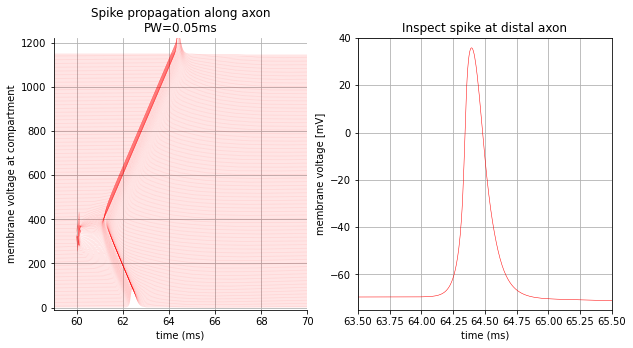

In [17]:
# Example of plotting voltage traces at all axonal segments, tracking spike
#  propagation along the membrane, expanding across space
fig, (ax,ax2) = plt.subplots(1,2,figsize=(10,5))
ax.grid()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

offset = -1*-70
offset_step = 2
for i in range(576):
    ax.plot(t_vec,vRec[i]+offset,'r',linewidth=0.1, alpha=0.5)

    offset += offset_step

dur = Stim['dur']
ax.set_title(f'Spike propagation along axon\nPW={dur}ms')
ax.set_xlabel('time (ms)')
ax.set_ylabel('membrane voltage at compartment')

ax.set_xlim(59,70)
ax.set_ylim(-10,int(576)*offset_step+70)

## Now, plot the spike just at the distal axon, noting timing difference
ax2.plot(t_vec,vRec[-1],'r',linewidth=0.5)

ax2.set_title('Inspect spike at distal axon')
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('membrane voltage [mV]')

ax2.grid()
ax2.set_xlim(63.5,65.5)
ax2.set_ylim(-75,40)

plt.show()

### Run threshold finding code

In [11]:
# Here, vRec is the voltage along the axon
thr_c, t_vec, vRec_cathodic = hf.lowerThreshold(Stim, RGC, lower=0, upper=5, num=25, epsilon=0.02)

Starting trial with 2.952934275127933 upper bound = 3.2378523774371812 lower bound = 2.668016172818685
Starting trial with 3.095393326282557 upper bound = 3.2378523774371812 lower bound = 2.952934275127933
Starting trial with 3.166622851859869 upper bound = 3.2378523774371812 lower bound = 3.095393326282557
Starting trial with 3.131008089071213 upper bound = 3.166622851859869 lower bound = 3.095393326282557
Starting trial with 3.148815470465541 upper bound = 3.166622851859869 lower bound = 3.131008089071213
Lower threshold found at:  3.148815470465541  uA


In [ ]:
print(len(vRec_cathodic))

In [ ]:
Stim['polarity'] = 1 # anodic == 1; cathodic == -1 

# Here, vRec is the voltage along the axon
thr_a, t_vec, vRec_anodic = hf.lowerThreshold(Stim, RGC, lower=0, upper=5, num=25, epsilon=0.02)

In [ ]:
print(len(vRec_anodic))

### Plot spike along axon

In [ ]:
# Example of plotting voltage traces at all axonal segments, tracking spike
#  propagation along the membrane, expanding across space
fig, (ax,ax2) = plt.subplots(1,2,figsize=(10,5))
ax.grid()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

offset = -1*-70
offset_step = 2
for i in range(576):
    ax.plot(t_vec,vRec_cathodic[i]+offset,'r',linewidth=0.1, alpha=0.5)
    ax.plot(t_vec,vRec_anodic[i]+offset,'k',linewidth=0.1, alpha=0.5)  

    offset += offset_step

dur = Stim['dur']
ax.set_title(f'Spike propagation along axon\nPW={dur}ms')
ax.set_xlabel('time (ms)')
ax.set_ylabel('membrane voltage at compartment')

ax.set_xlim(59,70)
ax.set_ylim(-10,int(576)*offset_step+70)

## Now, plot the spike just at the distal axon, noting timing difference
ax2.plot(t_vec,vRec_cathodic[-1],'r',linewidth=0.5)
ax2.plot(t_vec,vRec_anodic[-1],'k',linewidth=0.5)

ax2.set_title('Inspect spike at distal axon')
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('membrane voltage [mV]')

ax2.grid()
ax2.set_xlim(64.5,65.5)
ax2.set_ylim(-75,40)

plt.show()

# Find the timing of the peak value of vRec_cathodic[-1]
#  and vRec_anodic[-1]
peak_cathodic = t_vec[np.argmax(vRec_cathodic[-1])]
peak_anodic = t_vec[np.argmax(vRec_anodic[-1])]
print('cathodic timing: ', round(peak_cathodic,3), ' cathodic threshold: ', round(thr_c,3))
print('anodic timing: ', round(peak_anodic,3), ' anodic threshold: ', round(thr_a,3))
print('difference: ', round(peak_cathodic-peak_anodic,3))



## Re-run with truncated phases

In [ ]:
objs = [h.InGauss(seg.x,sec=RGC.SOCB) for seg in RGC.SOCB]

In [ ]:
## Inject noise into distal axon
# Update noise
#######################################################
########    inject channel noise into axon     ########
#######################################################
tstop = 80
dt = 0.005
current = 1.48
random_stream_offset_ = (tstop+1000)*1/dt * np.floor(current*10)
r = h.Random()
k=0
knoise = 0.00025*(1e3)
objs = [h.InGauss(seg.x,sec=RGC.axon) for seg in RGC.axon]
# objs = [h.InGauss(seg.x,sec=RGC.SOCB) for seg in RGC.SOCB]
for obj in objs:
    r.MCellRan4(random_stream_offset_*k) #TODO: change back to +k
    segment = obj.get_segment()

    obj.delay = 0
    obj.dur = tstop
    obj.mean = 0
    # TODO: change whether axonal or somatic
    obj.stdev = knoise*(np.sqrt(segment.area()*1e-8*1 \
                    * segment.gnabar_mammalian_spike*1e3))
    print(obj.stdev)
    obj.noiseFromRandom(r)
    
h.setpointers()

In [ ]:
## Inject noise into distal axon
# Update noise
#######################################################
########    inject channel noise into axon     ########
#######################################################
tstop = 80
dt = 0.005
current = 1.48
random_stream_offset_ = (tstop+1000)*1/dt * np.floor(current*10)
r = h.Random()
k=4
knoise = 0.00025*(1e3)
# objs = [h.InGauss(seg.x,sec=RGC.axon) for seg in RGC.axon]
objs = [h.InGauss(seg.x,sec=RGC.SOCB) for seg in RGC.SOCB]
for obj in objs:
    r.MCellRan4(random_stream_offset_*k) #TODO: change back to +k
    segment = obj.get_segment()

    obj.delay = 0
    obj.dur = tstop
    obj.mean = 0
    # TODO: change whether axonal or somatic
    obj.stdev = knoise*(np.sqrt(segment.area()*1e-8*1 \
                    * segment.gnabar_mammalian_spike*1e3))
    print(obj.stdev)
    obj.noiseFromRandom(r)
    
h.setpointers()

In [ ]:
### Most features of the stimulus are set up a struct (dict) called Stim 
Stim = {}

# temporal features of the sitmulus 
Stim['pulseShape'] = 'triphasic'
Stim['dt'] = .005 # units: [ms]
Stim['delay'] = 10 # units: [ms]
Stim['dur'] = 0.05 # units: [ms]
Stim['stop'] = 80 # units: [ms]
Stim['amp'] = 1.47  # units: [uA]

# calibration phase of the stimulus 
Stim['initDur'] = 50 # units: [ms]
Stim['initDt'] = 1 # units: [ms]
Stim['vInit'] = -70 # units: [mV]

# spatial features of the stimulus 
# --> specifically defining the electrode geometry 
Stim['electrodes'] = [[-100,0,59]] # units: [um] 
Stim['electrode_type'] = 'disk'
Stim['rhoExt'] = 1000 # Ohm*cm
Stim['elecDiam'] = 15 # um
Stim['polarity'] = -1 # anodic == 1; cathodic == -1 

Stim['pulseRatioTri'] = [-2/3,1,-1/3]
Stim['pulseRatioBi'] = [1,-1]
Stim['frequency'] = 10 # units: [Hz]

# have to set transfer impedances ANY TIME stimulus parameters are changed!! 
hf.setupTransferImpedance(Stim, RGC)

# Play the stimulus into the cell, setting it up for stimulation
Stim['amp'] = Stim['polarity']*Stim['amp']
tsvec, isvec = hf.setupStimulus(Stim)
isvec.play(h._ref_is_xtra, tsvec, 1) 

# set up recording vectors at every axonal segment 
vRec = []
for seg in RGC.axon:
    vRec.append(h.Vector().record(RGC.axon(seg.x)._ref_v))

# set up recoring vector for time in the simulation 
t_vec = h.Vector().record(h._ref_t)

# Initialization phase of the simulation 
h.init()
h.tstop = Stim['initDur']
h.dt = Stim['initDt']
h.finitialize(Stim['vInit'])
h.continuerun(h.tstop)

# Run the simulation 
h.tstop = Stim['initDur'] + Stim['stop']
h.steps_per_ms = int(1/Stim['dt'])
h.dt = Stim['dt']
h.continuerun(h.tstop)
print('***** sim done *****')

### Plot the run

In [ ]:
# Example of plotting voltage traces at all axonal segments, tracking spike
#  propagation along the membrane, expanding across space
fig, (ax,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax.grid()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

offset = -1*-70
offset_step = 2
for i in range(576):
    ax.plot(t_vec,vRec[i]+offset,'k',linewidth=0.1, alpha=0.5)

    offset += offset_step

dur = Stim['dur']
ax.set_title(f'Spike propagation along axon\nPW={dur}ms')
ax.set_xlabel('time (ms)')
ax.set_ylabel('membrane voltage at compartment')

ax.set_xlim(59,70)
ax.set_ylim(-10,int(576)*offset_step+70)

## Now, plot the spike just at the distal axon, noting timing difference
ax2.plot(t_vec,vRec[-1],'k',linewidth=2)

ax2.set_title('Inspect noise in steady state')
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('membrane voltage [mV]')

ax2.grid()
ax2.set_xlim(30,50)
ax2.set_ylim(-73,-68)
# ax2.set_ylim(-2.3,1.5) # cathodic 
# ax2.set_ylim(-1.5,2.2) # anodic

## Now, plot the spike just at the distal axon, noting timing difference
ax3.plot(t_vec,vRec[-1],'k',linewidth=1)

ax3.set_title('Inspect spike at distal axon')
ax3.set_xlabel('time (ms)')
ax3.set_ylabel('membrane voltage [mV]')

ax3.grid()
# ax3.set_xlim(64.5,65.5)
ax3.set_xlim(63,65)
# ax3.set_ylim(-75,40)
ax3.set_ylim(-90,30)

plt.show()

peak_time = t_vec[np.argmax(vRec[0])]
print('timing after stim: ', (round(peak_time,3)-60.150))

### Setup recording vectors

In [ ]:
### Recording vectors are set up to detect membrane voltage at various segmenets
###  along the cell. This is key to understanding how the cell responds to the
###  stimulus! 

# single recording vector at the center of the soma
vRec_soma = h.Vector().record(RGC.cell.soma(0.5)._ref_v)

# single recording vector at the center of the sodium channel band 
vRec_SOCB = h.Vector().record(RGC.SOCB(0.5)._ref_v)

# set up recording vectors at every axonal segment 
vRec_allSegs_axon = []
for seg in RGC.axon:
    vRec_allSegs_axon.append(h.Vector().record(RGC.axon(seg.x)._ref_v))

# set up recoring vector for time in the simulation 
t = h.Vector().record(h._ref_t)

# set up action potential detection vector, informs when an action potential
#  was detected at a given segment 
APC_axon = h.APCount(1, sec = RGC.axon) # searching at the end of the axon
APC_axon.thresh = 0 # units: [mV]


### Run the simulation 

In [ ]:
# Play the stimulus into the cell, setting it up for stimulation
Stim['amp'] = Stim['polarity']*Stim['amp']
tsvec, isvec = hf.setupStimulus(Stim)
isvec.play(h._ref_is_xtra, tsvec, 1) 

# Initialization phase of the simulation 
h.init()
h.tstop = Stim['initDur']
h.dt = Stim['initDt']
h.finitialize(Stim['vInit'])
h.continuerun(h.tstop)

# Run the simulation 
h.tstop = Stim['initDur'] + Stim['stop']
h.steps_per_ms = int(1/Stim['dt'])
h.dt = Stim['dt']
h.continuerun(h.tstop)
print('***** sim done *****')

In [ ]:
# Plot stimulus waveform
plt.plot(tsvec,isvec*1000)
plt.xlim([59.8,60.5])
plt.xlabel('time (ms)')
plt.ylabel('current (uA)')

### Plot recording vectors to understand result of the simulation 

In [ ]:
# convert NEURON recording vectors to np arrays for plotting
t_plot = np.array(t)
vRec_soma_plot = np.array(vRec_soma)
vRec_SOCB_plot = np.array(vRec_SOCB)
vRec_allSegs_axon_plot = np.array(vRec_allSegs_axon)

In [ ]:
# Example of plotting just a single voltage trace at the soma, SOCB, and axon
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.plot(t,vRec_soma_plot,'k',linewidth=1)
ax.plot(t,vRec_SOCB_plot,'r',linewidth=1)
ax.plot(t,vRec_allSegs_axon_plot[-1],'b',linewidth=1)

ax.legend(['soma','SOCB','axon'],loc='upper right',frameon=True)

ax.set_title('Plotting single voltage traces at several compartments')
ax.set_xlabel('time (ms)')
ax.set_ylabel('membrane voltage (mV)')

ax.set_xlim(59,67)
ax.set_ylim(-150,70)
plt.show()

In [ ]:
# Example of plotting voltage traces at all axonal segments, tracking spike
#  propagation along the membrane, collapsing across space 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

for i in range(RGC.axon.nseg):
    if i == RGC.axon.nseg/2:
        # color middle compartment with a red trace
        plt.plot(t_plot,vRec_allSegs_axon_plot[i],'r',linewidth=1) 
    else:
        plt.plot(t_plot,vRec_allSegs_axon_plot[i],'b',linewidth=0.01)

ax.set_title('Plotting voltage traces along the axon, collapse in space')
ax.set_xlabel('time (ms)')
ax.set_ylabel('membrane voltage (mV)')

ax.set_xlim(59,70)
ax.set_ylim(-100,50)
plt.show()

In [ ]:
# Example of plotting voltage traces at all axonal segments, tracking spike
#  propagation along the membrane, expanding across space
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

offset = -1*Stim['vInit']
offset_step = 2
for i in range(RGC.axon.nseg):
    if i == RGC.axon.nseg/2:
        # color middle compartment with a red trace
        plt.plot(t_plot,vRec_allSegs_axon_plot[i]+offset,'r',linewidth=0.5) 
    else:
        plt.plot(t_plot,vRec_allSegs_axon_plot[i]+offset,'b',linewidth=0.1)
    offset += offset_step

ax.set_title('Plotting voltage traces along the axon, expanded in space')
ax.set_xlabel('time (ms)')
ax.set_ylabel('membrane voltage at compartment')

ax.set_xlim(59,70)
ax.set_ylim(-10,int(RGC.axon.nseg)*offset_step+70)
plt.show()